Starting anomaly detection pipeline...

Detecting anomalies...

Processing Period 2:
Anomalies found in Period 2 (6 anomalies):
 - 1928-04-26
 - 1928-04-27
 - 1928-05-14
 - 1928-05-15
 - 1928-05-22
 - 1928-05-23

Processing Period 3:


/var/folders/m3/y36hmjps0_l0clt9plgsskrw0000gn/T/ipykernel_37143/2958420875.py:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


Anomalies found in Period 3 (7 anomalies):
 - 1928-07-12
 - 1928-08-17
 - 1928-09-14
 - 1928-09-25
 - 1928-11-15
 - 1928-11-20
 - 1928-11-21

Processing Period 4:
Anomalies found in Period 4 (7 anomalies):
 - 1928-12-06
 - 1928-12-31
 - 1929-01-02
 - 1929-01-03
 - 1929-03-04
 - 1929-03-25
 - 1929-03-27

Processing Period 5:
Anomalies found in Period 5 (7 anomalies):
 - 1929-07-22
 - 1929-10-28
 - 1929-10-29
 - 1929-10-30
 - 1929-10-31
 - 1929-11-06
 - 1929-11-14

Processing Period 6:
Anomalies found in Period 6 (7 anomalies):
 - 1929-12-03
 - 1929-12-12
 - 1929-12-13
 - 1929-12-16
 - 1930-04-01
 - 1930-05-05
 - 1930-05-06

Processing Period 7:
Anomalies found in Period 7 (7 anomalies):
 - 1930-06-09
 - 1930-06-10
 - 1930-06-16
 - 1930-06-18
 - 1930-06-19
 - 1930-07-14
 - 1930-09-12

Processing Period 8:
Anomalies found in Period 8 (7 anomalies):
 - 1930-12-02
 - 1931-01-07
 - 1931-01-08
 - 1931-01-27
 - 1931-04-08
 - 1931-04-24
 - 1931-04-30

Processing Period 9:
Anomalies found in Per

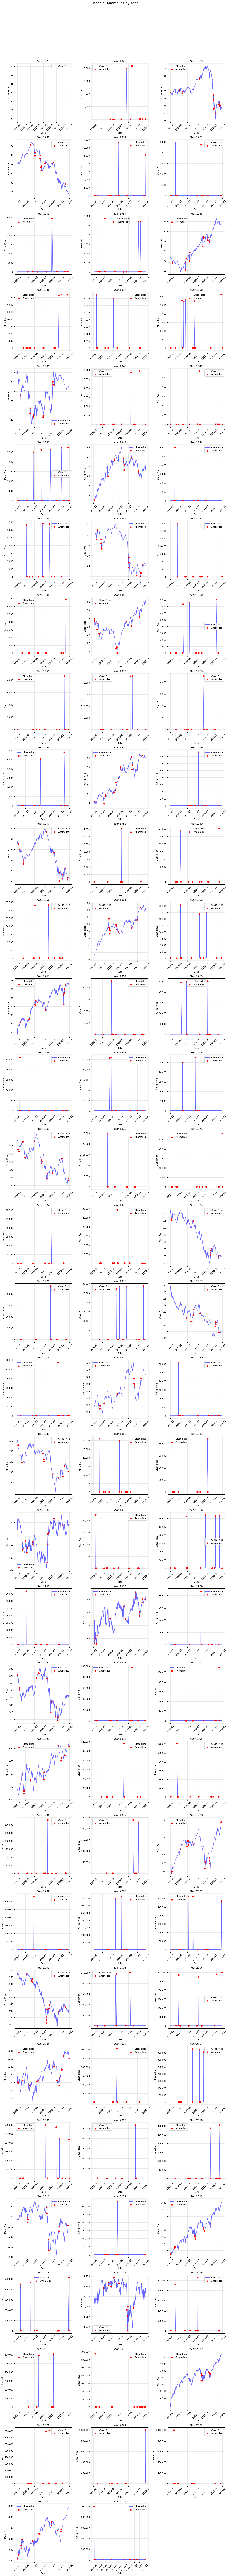

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

def detect_anomalies_by_period(file_path, contamination=0.05, max_value=1e6):
    """
    Detect anomalies in financial data using Isolation Forest, training separately for each 6-month period.
    
    Parameters:
    file_path (str): Path to the CSV file containing the data
    contamination (float): The proportion of outliers in the dataset (default=0.05)
    max_value (float): Maximum allowable value for features to handle extreme outliers (default=1e6)
    
    Returns:
    dict: Dictionary containing anomaly dates for each period
    DataFrame: Original dataframe with anomaly labels added
    """
    # Load and preprocess the dataset
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by='Date').reset_index(drop=True)
    
    # Handle infinity values by replacing them with NaN
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Fill missing values
    df.fillna(method='ffill', inplace=True)
    
    # Clip extreme values only on numeric columns
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    df[numeric_columns] = df[numeric_columns].clip(upper=max_value)
    
    # Create 6-month periods
    df['Period'] = ((df['Date'].dt.year - df['Date'].dt.year.min()) * 12 + 
                    df['Date'].dt.month)
    df['Period'] = (df['Period'] // 6).astype(int)
    
    # Features to use for anomaly detection
    feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    
    # Initialize dictionary for anomalies and array for all predictions
    anomalies_dict = {}
    df['Anomaly'] = 0
    
    # Process each period
    for period in df['Period'].unique():
        print(f"\nProcessing Period {period}:")
        
        # Get data for current period
        mask = df['Period'] == period
        period_data = df[mask].copy()
        
        # Skip if not enough data
        if len(period_data) < 10:
            print(f"Insufficient data in period {period}, skipping...")
            continue
        
        # Calculate features
        features = []
        
        # Daily returns (check for infinities after pct_change)
        returns = period_data[feature_columns].pct_change().fillna(0)
        returns.replace([np.inf, -np.inf], 0, inplace=True)
        features.append(returns)
        
        # Volatility (5-day rolling standard deviation)
        volatility = period_data[feature_columns].rolling(window=5).std().fillna(0)
        volatility.replace([np.inf, -np.inf], 0, inplace=True)
        features.append(volatility)
        
        # Volume ratio compared to 5-day average
        volume_ratio = (period_data['Volume'] / 
                       period_data['Volume'].rolling(window=5).mean()).fillna(1)
        volume_ratio.replace([np.inf, -np.inf], 1, inplace=True)
        features.append(pd.DataFrame({'Volume_Ratio': volume_ratio}))
        
        # Combine all features
        X = pd.concat(features, axis=1)
        
        # Ensure X has no extreme values
        X = X.clip(upper=max_value).fillna(0)
        X.replace([np.inf, -np.inf], 0, inplace=True)
        
        # Normalize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Train Isolation Forest
        iso_forest = IsolationForest(
            contamination=contamination,
            random_state=42,
            n_estimators=100,
            max_samples='auto'
        )
        
        # Fit and predict
        predictions = iso_forest.fit_predict(X_scaled)
        
        # Store predictions in main dataframe
        df.loc[mask, 'Anomaly'] = predictions
        
        # Store anomaly dates
        anomaly_dates = period_data.loc[predictions == -1, 'Date'].tolist()
        anomalies_dict[period] = anomaly_dates
        
        # Print anomalies for this period
        print(f"Anomalies found in Period {period} ({len(anomaly_dates)} anomalies):")
        for date in anomaly_dates:
            print(f" - {date.strftime('%Y-%m-%d')}")
    
    return anomalies_dict, df

def visualize_anomalies_by_year(df):
    """
    Visualize anomalies in the financial data with separate subplots for each year.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the financial data with anomaly labels
    """
    # Add year column if not present
    df = df.copy()
    df['Year'] = df['Date'].dt.year
    
    # Get unique years
    years = sorted(df['Year'].unique())
    num_years = len(years)
    
    # Calculate subplot layout
    num_rows = (num_years + 2) // 3  # 3 plots per row, rounded up
    num_cols = min(3, num_years)
    
    # Create figure with subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
    fig.suptitle('Financial Anomalies by Year', fontsize=16, y=1.02)
    
    # Flatten axes array for easier iteration
    if num_rows == 1:
        axes = [axes] if num_cols == 1 else axes
    else:
        axes = axes.flatten()
    
    # Plot each year
    for idx, year in enumerate(years):
        ax = axes[idx]
        year_data = df[df['Year'] == year]
        
        # Plot regular data
        ax.plot(year_data['Date'], year_data['Close'], 
                label='Close Price', color='blue', alpha=0.6)
        
        # Plot anomalies
        anomalies = year_data[year_data['Anomaly'] == -1]
        if not anomalies.empty:
            ax.scatter(anomalies['Date'], anomalies['Close'], 
                      color='red', label='Anomalies', zorder=5)
        
        # Customize subplot
        ax.set_title(f'Year {year}')
        ax.set_xlabel('Date')
        ax.set_ylabel('Close Price')
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        # Rotate x-axis labels for better readability
        ax.tick_params(axis='x', rotation=45)
        
        # Format y-axis with appropriate scaling
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    # Remove any empty subplots
    for idx in range(len(years), len(axes)):
        fig.delaxes(axes[idx])
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    return fig

def analyze_anomalies_by_year(df):
    """
    Generate summary statistics for anomalies by year.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the financial data with anomaly labels
    
    Returns:
    pd.DataFrame: Summary statistics by year
    """
    df['Year'] = df['Date'].dt.year
    
    yearly_stats = []
    for year in sorted(df['Year'].unique()):
        year_data = df[df['Year'] == year]
        anomalies = year_data[year_data['Anomaly'] == -1]
        
        stats = {
            'Year': year,
            'Total_Days': len(year_data),
            'Anomaly_Count': len(anomalies),
            'Anomaly_Percentage': (len(anomalies) / len(year_data) * 100),
            'Avg_Close_Price': year_data['Close'].mean(),
            'Max_Close_Price': year_data['Close'].max(),
            'Min_Close_Price': year_data['Close'].min(),
            'Avg_Volume': year_data['Volume'].mean()
        }
        yearly_stats.append(stats)
    
    stats_df = pd.DataFrame(yearly_stats)
    stats_df['Anomaly_Percentage'] = stats_df['Anomaly_Percentage'].round(2)
    return stats_df

def save_results(df, stats_df, output_dir='results'):
    """
    Save the analysis results to files.
    
    Parameters:
    df (pd.DataFrame): DataFrame with anomaly labels
    stats_df (pd.DataFrame): DataFrame with yearly statistics
    output_dir (str): Directory to save results (default='results')
    """
    import os
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Save full results
    df.to_csv(os.path.join(output_dir, 'anomaly_results.csv'), index=False)
    
    # Save statistics
    stats_df.to_csv(os.path.join(output_dir, 'yearly_statistics.csv'), index=False)
    
    # Save plots
    fig = visualize_anomalies_by_year(df)
    fig.savefig(os.path.join(output_dir, 'anomaly_plots.png'), 
                bbox_inches='tight', dpi=300)
    plt.close(fig)

def main():
    """
    Main function to run the anomaly detection and analysis pipeline.
    """
    # Configuration
    input_file = 'train_processed.csv'  # Replace with your input file
    output_dir = 'results'
    contamination = 0.05
    
    print("Starting anomaly detection pipeline...")
    
    # Detect anomalies
    print("\nDetecting anomalies...")
    anomalies_dict, df_with_anomalies = detect_anomalies_by_period(
        input_file, 
        contamination=contamination
    )
    
    # Generate statistics
    print("\nGenerating yearly statistics...")
    stats_df = analyze_anomalies_by_year(df_with_anomalies)
    
    # Save all results
    print("\nSaving results...")
    save_results(df_with_anomalies, stats_df, output_dir)
    
    # Print summary
    print("\nSummary of Anomalies by Year:")
    print(stats_df.to_string(index=False))
    
    print(f"\nResults have been saved to the '{output_dir}' directory.")
    
    # Display plots
    fig = visualize_anomalies_by_year(df_with_anomalies)
    plt.show()

if __name__ == "__main__":
    main()